In [ ]:
import sys
if not sys.version.startswith("3.12"):
    raise RuntimeError("This notebook requires Python 3.12")

!pip install numpy pandas matplotlib seaborn scikit-learn torch psutil platform getpass

# Hardware and user spercifications

import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.datasets import load_breast_cancer

def print_system_info():
    print("="*60)
    print("SYSTEM INFORMATION")
    print("="*60)

    # OS and hardware
    print(f"Operating System : {platform.system()} {platform.release()}")
    print(f"Processor        : {platform.processor()}")
    print(f"CPU Cores        : {psutil.cpu_count(logical=True)}")
    print(f"RAM              : {round(psutil.virtual_memory().total / (1024**3), 2)} GB")

    # User
    print(f"PC Username      : {getpass.getuser()}")

    # Python and environment
    print(f"Python Version   : {platform.python_version()}")
    print(f"Working Dir      : {os.getcwd()}")

    # GPU (if PyTorch is installed)
    if torch.cuda.is_available():
        print(f"GPU Device       : {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version     : {torch.version.cuda}")
    else:
        print("GPU Device       : None (CPU mode)")

    print("="*60)
    print()

print_system_info()

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [ ]:
# --- Data Loading and Preprocessing ---
data = load_breast_cancer()

X = data.data
y = data.target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
X_val_t = torch.FloatTensor(X_val_scaled)
y_val_t = torch.FloatTensor(y_val).reshape(-1, 1)

print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")

Training features shape: torch.Size([455, 30])
Validation features shape: torch.Size([114, 30])


In [ ]:
# --- Model Definition ---
class FeedForwardNet(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNet, self).__init__()
        
        # First hidden layer - 32 neurons
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        
        # Second hidden layer - 16 neurons
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        
        # Output layer - 1 neuron
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()  # Activation function to convert to a probability between 0-1
    
    def forward(self, x):
        # Pass first hidden layer
        x = self.fc1(x)
        x = self.relu1(x)
        
        # Pass second hidden layer
        x = self.fc2(x)
        x = self.relu2(x)
        
        # Pass output layer
        x = self.fc3(x)
        x = self.sigmoid(x) 
        
        return x
    
input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- 3. Model Class Defined ---")

Model will accept 30 input features.
--- 3. Model Class Defined ---


In [ ]:
def calculate_full_loss(model, criterion, X, y):
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train() # Set model back to train mode
    return loss.item()

def stochastic_gradient_descent(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                max_iterations, check_every, patience, threshold):

    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    best_val_loss = float('inf')
    best_model_state = None
    stop_iteration = None
    patience_counter = 0
    prev_val_loss = float('inf')
    
    # Shuffle training data
    indices = torch.randperm(n_samples)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    for i in range(max_iterations + 1):
        # Select one sample
        idx = i % n_samples
        
        # Reshuffle after going through all samples
        if idx == 0 and i > 0:
            indices = torch.randperm(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
        
        # Get single training sample
        X_sample = X_train_shuffled[idx:idx+1]
        y_sample = y_train_shuffled[idx:idx+1]
        
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        output = model(X_sample)
        loss = criterion(output, y_sample)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Check and record losses every check_every iterations
        if i % check_every == 0:
            # Calculate loss
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)
            
            # Plotting data
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)
            
            # Early stopping
            if stop_iteration is None:
                loss_improvement = prev_val_loss - val_loss
                
                if loss_improvement > threshold:
                    # Reset patience counter
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    # Loss improve by the threshold
                    patience_counter += 1
                
                # Print stopping information
                if patience_counter >= patience:
                    stop_iteration = i
                    print(f"\nEarly stopping at {stop_iteration}")
                    print(f"Best validation loss: {best_val_loss:.6f}")
                
                prev_val_loss = val_loss
    
    # Use final model if early stopping didn't work
    if best_model_state is None:
        best_model_state = model.state_dict().copy()
        stop_iteration = max_iterations

    return train_losses, val_losses, iterations, stop_iteration, best_model_state


Early stopping at 2500
Best validation loss: 0.071705
Plotting Part 1 results...


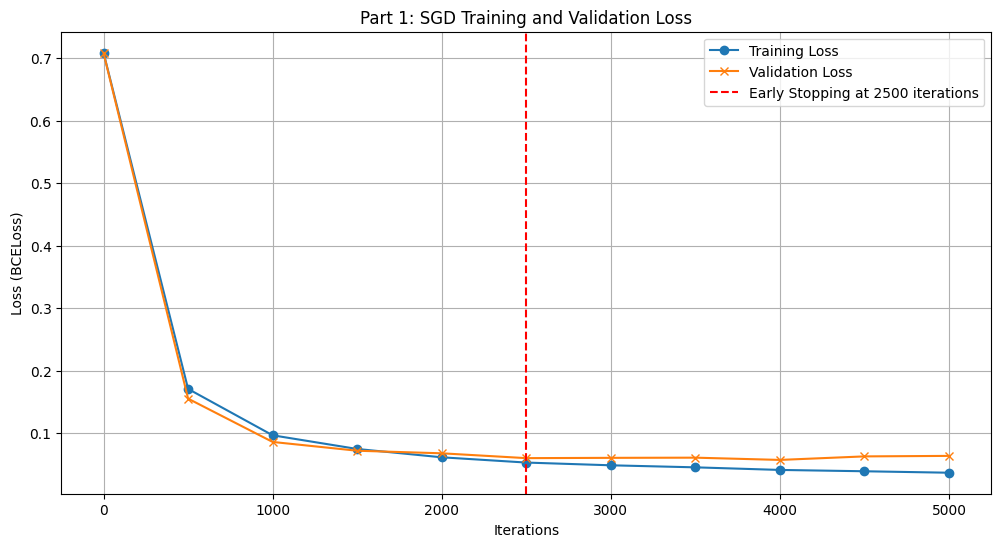


Accuracy of Early-Stopped Model on Validation Set: 98.25%


In [ ]:
# --- Hyperparameters for Part 1 ---
LEARNING_RATE = 0.01 
MAX_ITERATIONS = 5000 
CHECK_EVERY = 500 
PATIENCE = 2
THRESHOLD = 1e-2

# --- Model Initialization ---
model_sgd = FeedForwardNet(input_features)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_sgd.parameters(), lr=LEARNING_RATE)

# --- Run Training ---
train_losses_sgd, val_losses_sgd, iterations_sgd, stop_iter, best_model_state = stochastic_gradient_descent(
    model_sgd, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    MAX_ITERATIONS, CHECK_EVERY, PATIENCE, THRESHOLD
)

# --- Plotting Results ---
print("Plotting Part 1 results...")
plt.figure(figsize=(12, 6))
plt.plot(iterations_sgd, train_losses_sgd, label='Training Loss', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='Validation Loss', marker='x')
plt.axvline(x=stop_iter, color='red', linestyle='--',
            label=f'Early Stopping at {stop_iter} iterations')
plt.title('Part 1: SGD Training and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Accuracy ---
model_sgd.load_state_dict(best_model_state)
model_sgd.eval()

with torch.no_grad():

    predictions = model_sgd(X_val_t)
    predicted_classes = (predictions > 0.5).float()
    accuracy = (predicted_classes == y_val_t).float().mean()

    print(f"\nAccuracy of Early-Stopped Model on Validation Set: {accuracy * 100:.2f}%")


In [ ]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                        num_iterations, batch_size, check_every):

    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []
    
    # Shuffle training data at start
    indices = torch.randperm(n_samples)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    current_idx = 0 
    
    for i in range(num_iterations + 1):

        # If not enough samples left for a full batch
        if current_idx + batch_size > n_samples:
            # Reshuffle
            indices = torch.randperm(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            current_idx = 0 
        
        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        
        current_idx += batch_size
        
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Check and record losses
        if i % check_every == 0:
            # Calculate loss
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)
            
            # Plotting data
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)

    return train_losses, val_losses, iterations, model # Return the final model

Plotting Part 2 comparison...


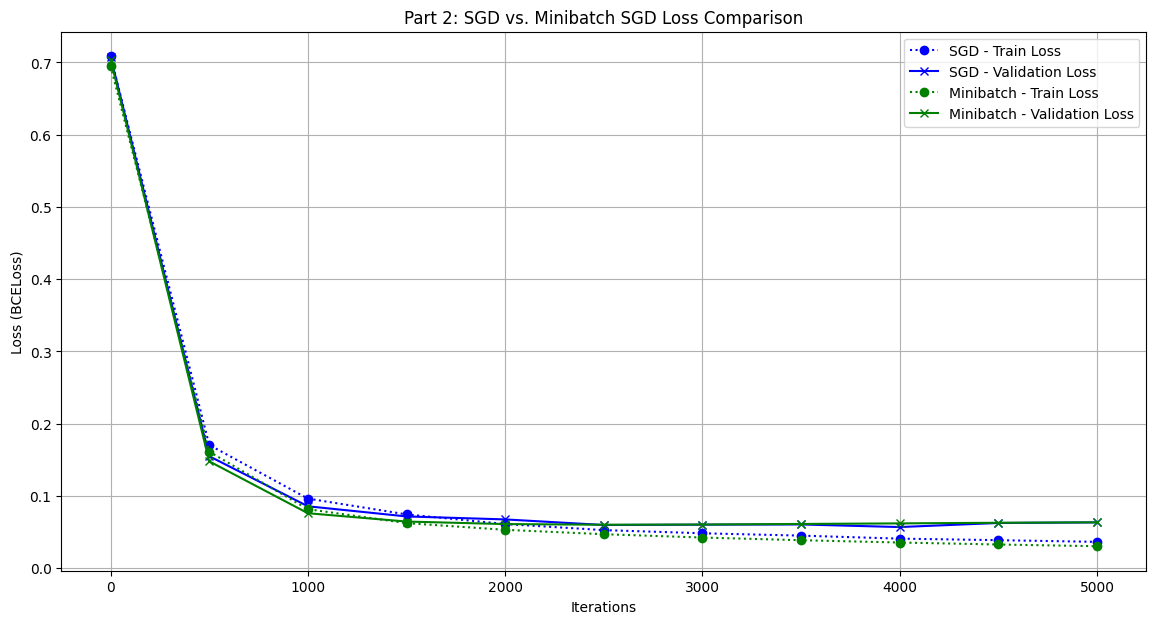

In [ ]:
# --- Hyperparameters for Part 2 ---
LEARNING_RATE_MB = 0.01
NUM_ITERATIONS_MB = 5000
BATCH_SIZE = 32
CHECK_EVERY_MB = 500

# --- Model Initialization ---
model_mb = FeedForwardNet(input_features)
criterion_mb = nn.BCELoss()
optimizer_mb = optim.SGD(model_mb.parameters(), lr=LEARNING_RATE_MB)

# --- Run Minibatch Training ---
train_losses_mb, val_losses_mb, iterations_mb, model_mb = train_with_minibatch(
    model_mb, criterion_mb, optimizer_mb,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_MB, BATCH_SIZE, CHECK_EVERY_MB
)

# --- Plotting Comparison ---
print("Plotting Part 2 comparison...")
plt.figure(figsize=(14, 7))

# SGD (Part 1)
plt.plot(iterations_sgd, train_losses_sgd, label='SGD - Train Loss', linestyle=':', color='blue', marker='o')
plt.plot(iterations_sgd, val_losses_sgd, label='SGD - Validation Loss', linestyle='-', color='blue', marker='x')

# Minibatch (Part 2)
plt.plot(iterations_mb, train_losses_mb, label='Minibatch - Train Loss', linestyle=':', color='green', marker='o')
plt.plot(iterations_mb, val_losses_mb, label='Minibatch - Validation Loss', linestyle='-', color='green', marker='x')

plt.title('Part 2: SGD vs. Minibatch SGD Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss (BCELoss)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Performance Metrics Comparison ---

def get_metrics(model, X_val, y_val):
    model.eval()
    with torch.no_grad():

        y_pred_prob = model(X_val)
        y_pred = (y_pred_prob > 0.5).int()
        y_true = y_val.int()

        y_pred = y_pred.squeeze()
        y_true = y_true.squeeze()
        
        # Calculate true positives, false positives, false negatives, true negatives
        TP = ((y_pred == 1) & (y_true == 1)).sum().item()
        FP = ((y_pred == 1) & (y_true == 0)).sum().item()
        FN = ((y_pred == 0) & (y_true == 1)).sum().item()
        TN = ((y_pred == 0) & (y_true == 0)).sum().item()
        
        # Accuracy
        acc = (TP + TN) / (TP + TN + FP + FN)
        
        # Precision
        pre = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        
        # Recall
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        
    return acc, pre, rec

# Get metrics for Part 1 (Early-Stopped SGD Model)
acc_sgd, pre_sgd, rec_sgd = get_metrics(model_sgd, X_val_t, y_val_t)

# Get metrics for Part 2 (Final Minibatch Model)
acc_mb, pre_mb, rec_mb = get_metrics(model_mb, X_val_t, y_val_t)

# --- Show Results in a Table ---
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Part 1: Early-Stopped SGD': [f"{acc_sgd:.4f}", f"{pre_sgd:.4f}", f"{rec_sgd:.4f}"],
    'Part 2: Minibatch SGD': [f"{acc_mb:.4f}", f"{pre_mb:.4f}", f"{rec_mb:.4f}"]
}

results_df = pd.DataFrame(results)
print("\n--- Final Performance Metrics on Validation Set ---")

from IPython.display import display
display(results_df)



--- Final Performance Metrics on Validation Set ---


,Metric,Part 1: Early-Stopped SGD,Part 2: Minibatch SGD
0,Accuracy,0.9825,0.9737
1,Precision,0.9859,0.9857
2,Recall,0.9859,0.9718


In [ ]:
class FeedForwardNetWithDropout(nn.Module):
    def __init__(self, input_size, dropout_rate=0.0):
        super(FeedForwardNetWithDropout, self).__init__()

        # First hidden layer - 32 neurons, with dropout
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        # Second hidden layer - 16 neurons, with dropout
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        
        # Output layer - 1 neuron 
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First hidden layer, with dropout
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Second hidden layer, with dropout
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Output layer
        x = self.fc3(x)
        out = self.sigmoid(x)

        return out


In [ ]:
def calculate_accuracy(model, X, y):

    model.eval()

    with torch.no_grad():
        outputs = model(X) 
        predictions = (outputs > 0.5).float() 
        accuracy = (predictions == y).float().mean().item() 

    return accuracy


In [ ]:
def train_with_dropout(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                                num_iterations, batch_size, check_every):

    n_samples = X_train.shape[0]
    train_losses, val_losses, train_accs, val_accs, iterations = [], [], [], [], []
    
    # Shuffle training data
    indices = torch.randperm(n_samples)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    current_idx = 0
    
    for i in range(num_iterations + 1):
        
        # If not enough samples left for a full batch
        if current_idx + batch_size > n_samples:
            # Reshuffle
            indices = torch.randperm(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            current_idx = 0 
        
        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        
        current_idx += batch_size
        
        # Training with dropout
        model.train() 
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Check and record losses 
        if i % check_every == 0:
            # Calculate loss
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)
            
            # Calculate accuracy
            train_acc = calculate_accuracy(model, X_train, y_train)
            val_acc = calculate_accuracy(model, X_val, y_val)
            
            # Plotting data
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            iterations.append(i)

    return train_losses, val_losses, train_accs, val_accs, iterations

In [ ]:
DROPOUT_RATES = [0.1, 0.3, 0.5]
LEARNING_RATE_DROPOUT = 0.01
NUM_ITERATIONS_DROPOUT = 5000
BATCH_SIZE_DROPOUT = 32
CHECK_EVERY_DROPOUT = 500

dropout_results = {}

for dropout_rate in DROPOUT_RATES:
    print(f"\n--- Training with Dropout Rate = {dropout_rate} ---")

    model = FeedForwardNetWithDropout(input_features, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_DROPOUT)


    # Train the model
    train_losses, val_losses, train_accs, val_accs, iterations = train_with_dropout(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_DROPOUT, BATCH_SIZE_DROPOUT, CHECK_EVERY_DROPOUT
    )

    # Store results for later comparison
    dropout_results[dropout_rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'iterations': iterations,
        'model': model
    }

    print(f"Final Training Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]*100:.2f}%")



--- Training with Dropout Rate = 0.1 ---
Final Training Accuracy: 99.34%
Final Validation Accuracy: 97.37%

--- Training with Dropout Rate = 0.3 ---
Final Training Accuracy: 99.12%
Final Validation Accuracy: 98.25%

--- Training with Dropout Rate = 0.5 ---
Final Training Accuracy: 98.68%
Final Validation Accuracy: 99.12%


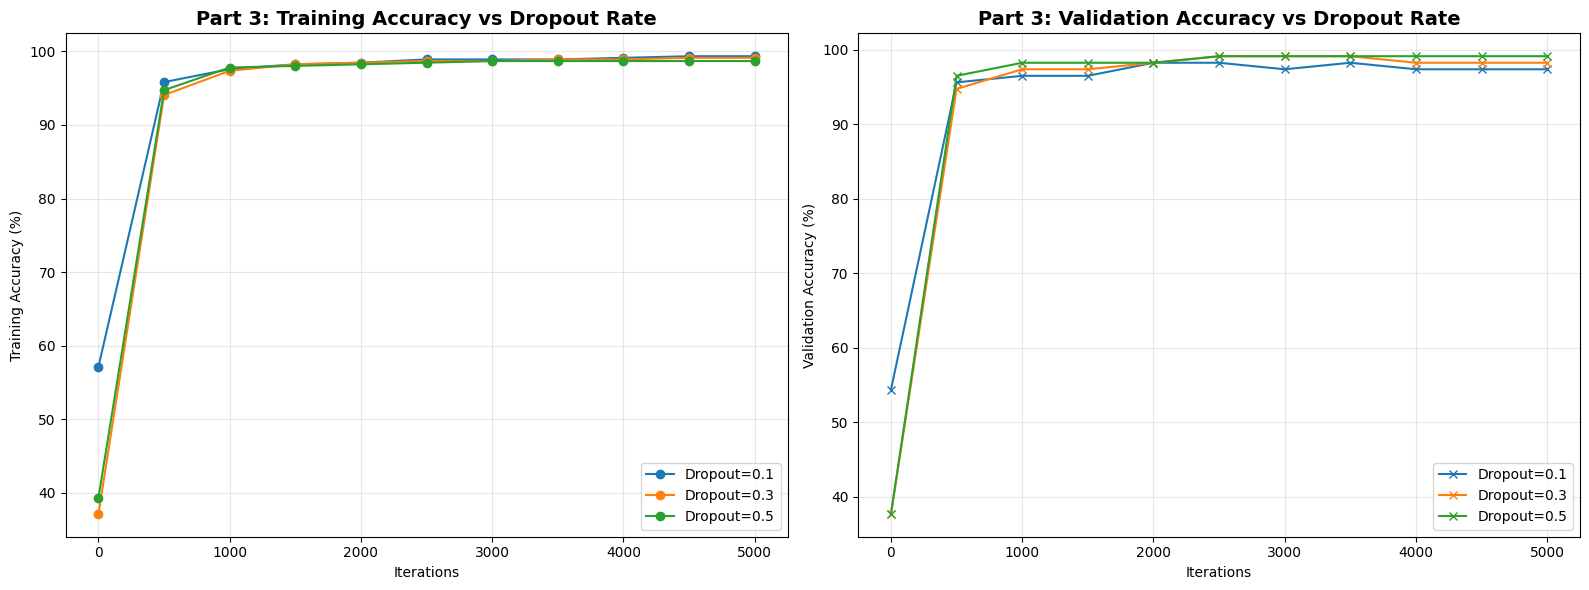

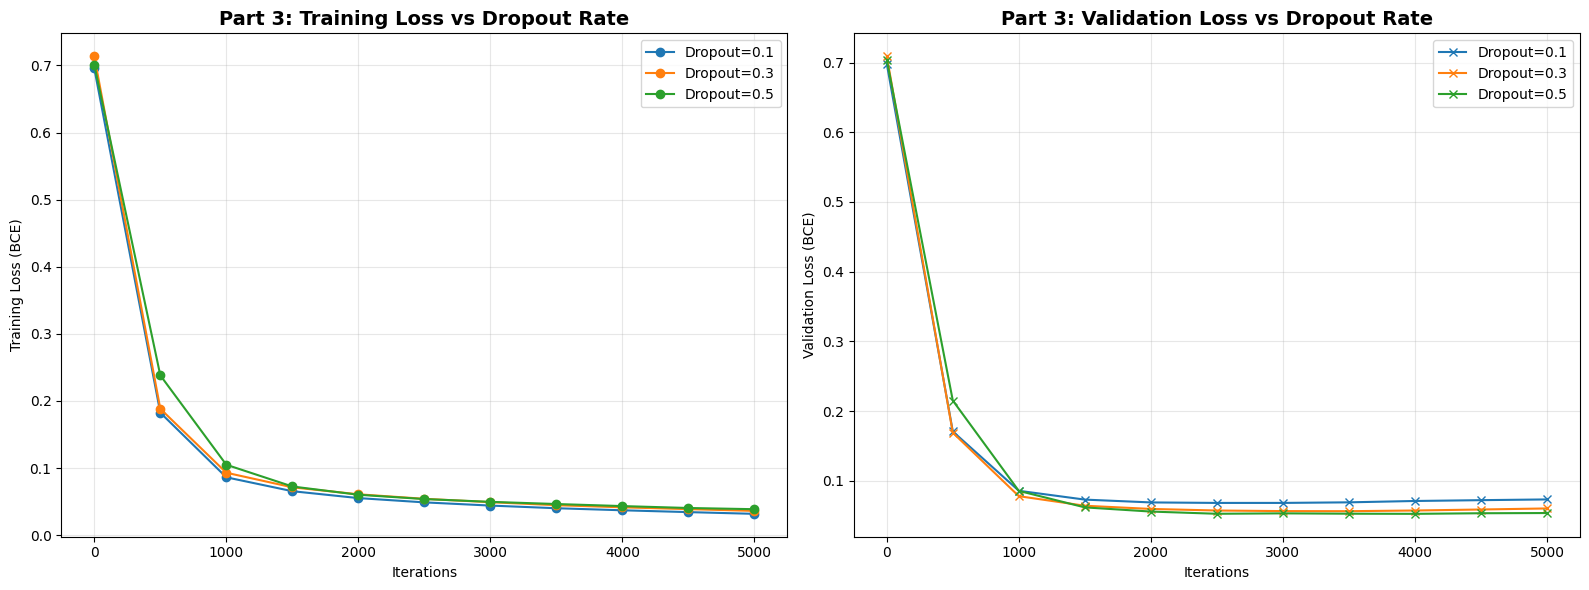

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for dropout_rate in DROPOUT_RATES:
    results = dropout_results[dropout_rate]
    axes[0].plot(results['iterations'], 
                [acc * 100 for acc in results['train_accs']], 
                label=f'Dropout={dropout_rate}', 
                marker='o')

axes[0].set_title('Part 3: Training Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Accuracy (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dropout_rate in DROPOUT_RATES:
    results = dropout_results[dropout_rate]
    axes[1].plot(results['iterations'], 
                [acc * 100 for acc in results['val_accs']], 
                label=f'Dropout={dropout_rate}', 
                marker='x')

axes[1].set_title('Part 3: Validation Accuracy vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for dropout_rate in DROPOUT_RATES:
    results = dropout_results[dropout_rate]
    axes[0].plot(results['iterations'], 
                results['train_losses'], 
                label=f'Dropout={dropout_rate}', 
                marker='o')
    
axes[0].set_title('Part 3: Training Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dropout_rate in DROPOUT_RATES:
    results = dropout_results[dropout_rate]
    axes[1].plot(results['iterations'], 
                results['val_losses'], 
                label=f'Dropout={dropout_rate}', 
                marker='x')

axes[1].set_title('Part 3: Validation Loss vs Dropout Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

dropout_summary = {
    'Dropout Rate': [],
    'Final Train Acc (%)': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': []
}

for dropout_rate in DROPOUT_RATES:
    results = dropout_results[dropout_rate]
    
    dropout_summary['Dropout Rate'].append(dropout_rate)
    dropout_summary['Final Train Acc (%)'].append(f"{results['train_accs'][-1] * 100:.2f}")
    dropout_summary['Final Val Acc (%)'].append(f"{results['val_accs'][-1] * 100:.2f}")
    dropout_summary['Final Train Loss'].append(f"{results['train_losses'][-1]:.4f}")
    dropout_summary['Final Val Loss'].append(f"{results['val_losses'][-1]:.4f}")

dropout_df = pd.DataFrame(dropout_summary)
display(dropout_df)


,Dropout Rate,Final Train Acc (%),Final Val Acc (%),Final Train Loss,Final Val Loss
0,0.1,99.34,97.37,0.0319,0.0734
1,0.3,99.12,98.25,0.0362,0.0604
2,0.5,98.68,99.12,0.0388,0.0538


In [ ]:
def train_with_minibatch_l2(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every):

    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        if i % check_every == 0:
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)


    return train_losses, val_losses, iterations


In [ ]:
def train_with_minibatch_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                            num_iterations, batch_size, check_every, lambda_l1):

    n_samples = X_train.shape[0]
    train_losses, val_losses, iterations = [], [], []

    X_train_shuffled = X_train.clone()
    y_train_shuffled = y_train.clone()
    current_idx = 0

    for i in range(num_iterations + 1):
        if current_idx + batch_size > n_samples:
            X_train_np, y_train_np = shuffle(X_train_shuffled.numpy(), y_train_shuffled.numpy(),
                                            random_state=random_seed + i)
            X_train_shuffled = torch.tensor(X_train_np, dtype=torch.float32)
            y_train_shuffled = torch.tensor(y_train_np, dtype=torch.float32)
            current_idx = 0

        X_batch = X_train_shuffled[current_idx : current_idx + batch_size]
        y_batch = y_train_shuffled[current_idx : current_idx + batch_size]
        current_idx += batch_size

        model.train()
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        l1_penalty = 0
        for param in model.parameters():
            l1_penalty += torch.sum(torch.abs(param))

        total_loss = loss + lambda_l1 * l1_penalty
        
        total_loss.backward()
        optimizer.step()
        
        if i % check_every == 0:
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)
            
    return train_losses, val_losses, iterations

In [ ]:
LAMBDA_L2_VALUES = [0, 1e-4, 1e-3]
LEARNING_RATE_L2 = 0.01 
NUM_ITERATIONS_L2 = 5000
BATCH_SIZE_L2 = 32
CHECK_EVERY_L2 = 500

l2_results = {}

for lambda_l2 in LAMBDA_L2_VALUES:
    print(f"\n--- Training with L2 λ = {lambda_l2} ---")

    model = FeedForwardNet(input_features)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE_L2, weight_decay=lambda_l2)

    train_losses, val_losses, iterations = train_with_minibatch_l2(
        model, criterion, optimizer,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2
    )

    final_accuracy = calculate_accuracy(model, X_val_t, y_val_t) 

    # Store results
    l2_results[lambda_l2] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'iterations': iterations,
        'final_accuracy': final_accuracy,
        'model': model
    }

    print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")


--- Training with L2 λ = 0 ---
Final Validation Accuracy: 96.49%

--- Training with L2 λ = 0.0001 ---
Final Validation Accuracy: 98.25%

--- Training with L2 λ = 0.001 ---
Final Validation Accuracy: 98.25%


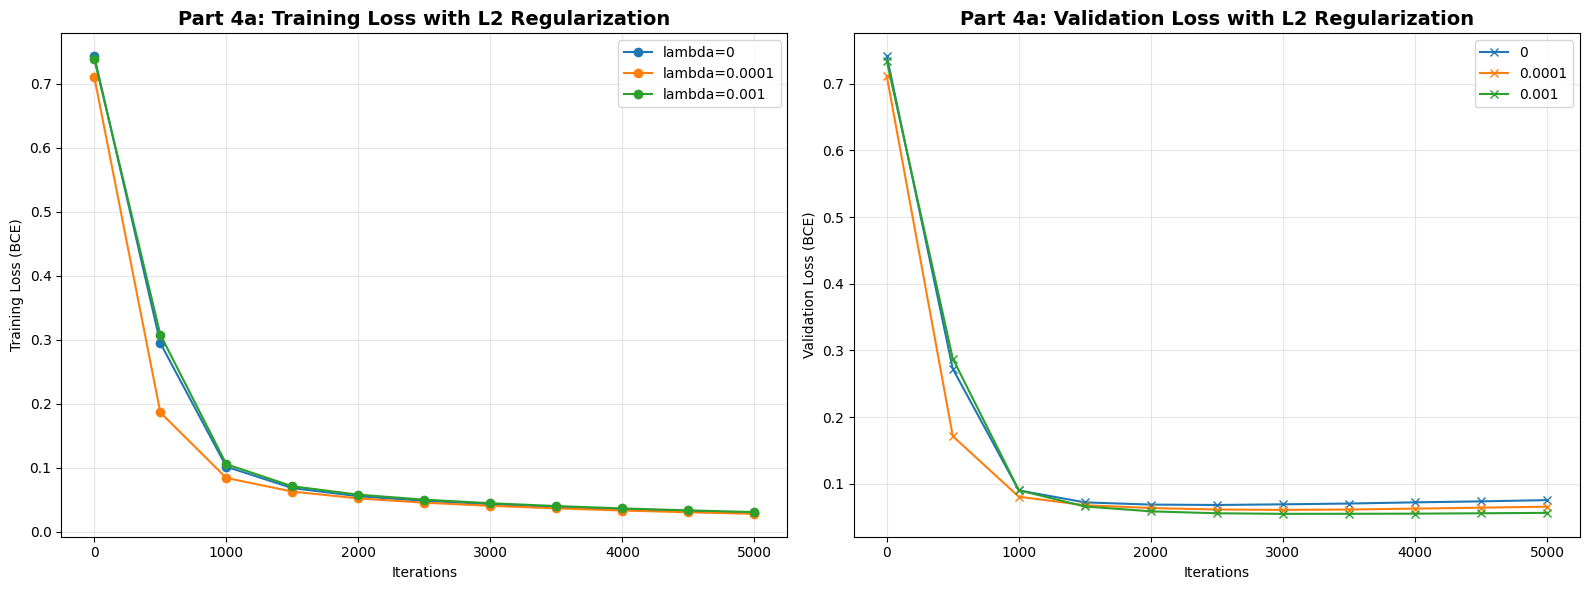

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for lambda_l2 in LAMBDA_L2_VALUES:
    results = l2_results[lambda_l2]
    axes[0].plot(results['iterations'], 
                results['train_losses'], 
                label=f'lambda={lambda_l2}', 
                marker='o')

axes[0].set_title('Part 4a: Training Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for lambda_l2 in LAMBDA_L2_VALUES:
    results = l2_results[lambda_l2]
    axes[1].plot(results['iterations'], 
                results['val_losses'], 
                label=f'{lambda_l2}', 
                marker='x')

axes[1].set_title('Part 4a: Validation Loss with L2 Regularization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
LAMBDA_L1 = 1e-4

model_l1 = FeedForwardNet(input_features)
criterion_l1 = nn.BCELoss()
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=LEARNING_RATE_L2)

# Train with L1
train_losses_l1, val_losses_l1, iterations_l1 = train_with_minibatch_l1(
    model_l1, criterion_l1, optimizer_l1,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS_L2, BATCH_SIZE_L2, CHECK_EVERY_L2, LAMBDA_L1
)

final_accuracy_l1 = calculate_accuracy(model_l1, X_val_t, y_val_t)

print(f"Final Validation Accuracy (L1): {final_accuracy_l1*100:.2f}%")

Final Validation Accuracy (L1): 98.25%


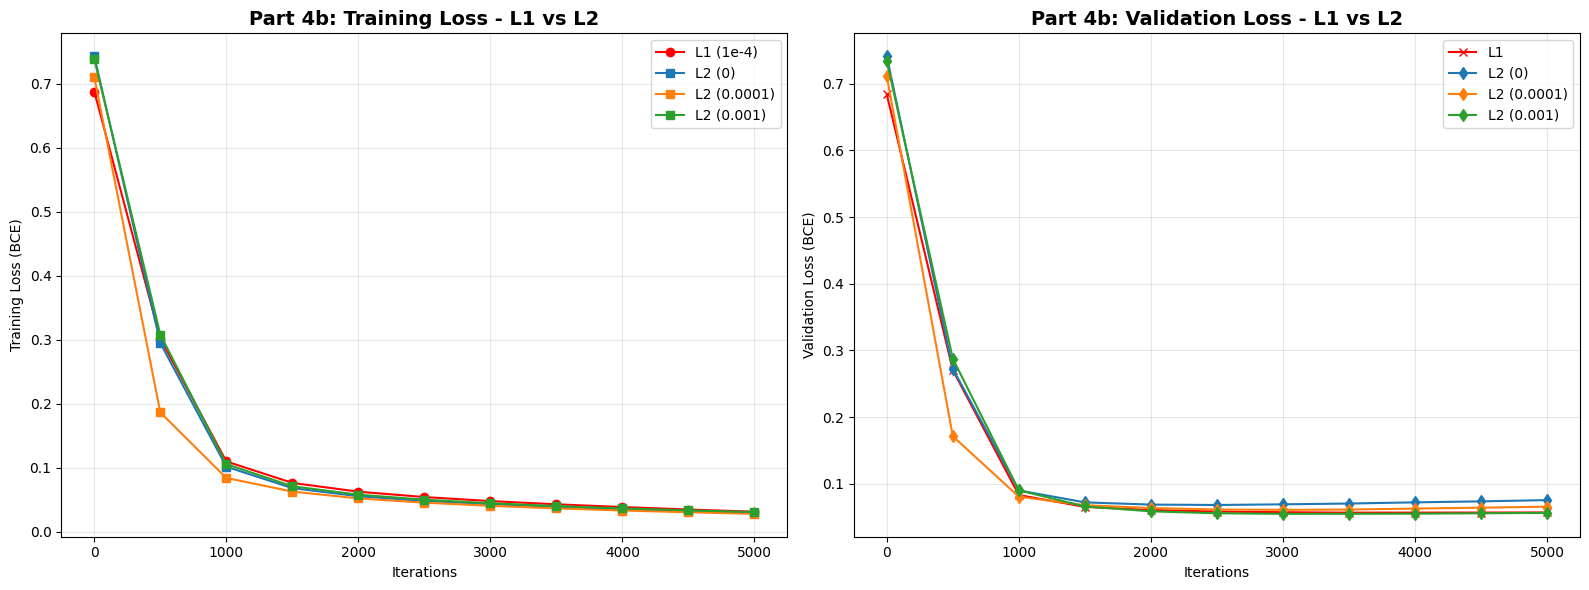

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(iterations_l1, train_losses_l1, label='L1 (1e-4)', marker='o', color='red')

for lambda_l2 in LAMBDA_L2_VALUES:
    results = l2_results[lambda_l2]
    axes[0].plot(results['iterations'], 
                results['train_losses'], 
                label=f'L2 ({lambda_l2})', 
                marker='s')

axes[0].set_title('Part 4b: Training Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Training Loss (BCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(iterations_l1, val_losses_l1, label='L1', marker='x', color='red')

for lambda_l2 in LAMBDA_L2_VALUES:
    results = l2_results[lambda_l2]
    axes[1].plot(results['iterations'], 
                results['val_losses'], 
                label=f'L2 ({lambda_l2})', 
                marker='d')

axes[1].set_title('Part 4b: Validation Loss - L1 vs L2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Validation Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
reg_summary = {
    'Regularization': [],
    'Final Val Acc (%)': [],
    'Final Train Loss': [],
    'Final Val Loss': [],
    'Sparsity (%)': []
}


def calculate_sparsity(model, threshold=1e-2):
    total_params = 0
    sparse_params = 0
    
    for param in model.parameters():
        total_params += param.numel()
        sparse_params += torch.sum(torch.abs(param) < threshold).item()
    
    sparsity = (sparse_params / total_params) * 100
    return sparsity

# No regularization
reg_summary['Regularization'].append('None')
reg_summary['Final Val Acc (%)'].append(f"{l2_results[0]['final_accuracy'] * 100:.2f}")
reg_summary['Final Train Loss'].append(f"{l2_results[0]['train_losses'][-1]:.4f}")
reg_summary['Final Val Loss'].append(f"{l2_results[0]['val_losses'][-1]:.4f}")
reg_summary['Sparsity (%)'].append(f"{calculate_sparsity(l2_results[0]['model']):.2f}")

# L2 (1e-4)
reg_summary['Regularization'].append('L2 (1e-4)')
reg_summary['Final Val Acc (%)'].append(f"{l2_results[1e-4]['final_accuracy'] * 100:.2f}")
reg_summary['Final Train Loss'].append(f"{l2_results[1e-4]['train_losses'][-1]:.4f}")
reg_summary['Final Val Loss'].append(f"{l2_results[1e-4]['val_losses'][-1]:.4f}")
reg_summary['Sparsity (%)'].append(f"{calculate_sparsity(l2_results[1e-4]['model']):.2f}")

# L2 (1e-3)
reg_summary['Regularization'].append('L2 (1e-3)')
reg_summary['Final Val Acc (%)'].append(f"{l2_results[1e-3]['final_accuracy'] * 100:.2f}")
reg_summary['Final Train Loss'].append(f"{l2_results[1e-3]['train_losses'][-1]:.4f}")
reg_summary['Final Val Loss'].append(f"{l2_results[1e-3]['val_losses'][-1]:.4f}")
reg_summary['Sparsity (%)'].append(f"{calculate_sparsity(l2_results[1e-3]['model']):.2f}")

# L1 (1e-4)
reg_summary['Regularization'].append('L1 (1e-4)')
reg_summary['Final Val Acc (%)'].append(f"{final_accuracy_l1 * 100:.2f}")
reg_summary['Final Train Loss'].append(f"{train_losses_l1[-1]:.4f}")
reg_summary['Final Val Loss'].append(f"{val_losses_l1[-1]:.4f}")
reg_summary['Sparsity (%)'].append(f"{calculate_sparsity(model_l1):.2f}")

reg_df = pd.DataFrame(reg_summary)
display(reg_df)


,Regularization,Final Val Acc (%),Final Train Loss,Final Val Loss,Sparsity (%)
0,None,96.49,0.0291,0.0754,3.84
1,L2 (1e-4),98.25,0.0276,0.0655,4.68
2,L2 (1e-3),98.25,0.0303,0.0563,5.66
3,L1 (1e-4),98.25,0.0309,0.0569,7.29
